In [1]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import pandas as pd
import ast
import numpy as np
from datetime import datetime as dt
import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar

from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol, order_value
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import matplotlib.pyplot as plt

import quantstats as qs
import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission

In [2]:
bundle = 'snp500'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
tickers = [coin.symbol for coin in assets]

In [3]:
import pandas as pd

def initialize(context):
    

   

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))


def handle_data(context, data):
    pricedic = {}
    asset = symbol('AAPL')
    real_price_history = data.history(asset, 'price', bar_count=15, frequency='1d')
    real_sma_15_days = real_price_history.mean()
    # Get the current price of AAPL
    price = data.current(asset,'price')

    
    if price > real_sma_15_days :
        order_value(symbol('AAPL'), 1000)
        pricedic[asset] = (data.current(asset, 'price'))
    elif price < real_sma_15_days :
        order_value(symbol('AAPL'), -1000)
        pricedic[asset] = (data.current(asset, 'price'))
        
    record(PRI=pricedic)

In [4]:
start = '2018-05-24'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start),
    end=pd.Timestamp(end),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-05-25   2018-05-25
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          60.46%       421.31%
Active Return              0.0%         360.85%
CAGR﹪                     6.62%        25.07%

Sharpe                     0.54         0.98
Prob. Sharpe Ratio         88.58%       98.66%
Smart Sharpe               0.47         0.85
Sortino                    0.75         1.47
Smart Sortino              0.65         1.28
Sortino/√2                 0.53         1.04
Smart Sortino/√2           0.46         0.9
Omega                      1.21         1.21

Max Drawdown               -33.92%      -42.43%
Longest DD Days            541          522
Volatility (ann.)          21.58%       42.31%
R^2                        0.61         0.61
Information Rati

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-04,2023-01-05,2023-06-09,522,-42.427595,-39.250753
2,2020-02-13,2020-03-23,2020-06-04,113,-41.275581,-39.432772
3,2020-09-02,2020-09-18,2020-12-24,114,-28.127467,-27.823316
4,2021-01-27,2021-03-08,2021-07-06,161,-26.247399,-22.770542
5,2021-09-08,2021-10-04,2021-11-17,71,-15.746747,-14.173000


Slippage: 148.92400000009442
Slippage Lost: 99.70200000022572
Total Commission: 43.191


Average Long Exposure = 338368.11140795634
Average Short Exposure = -262.20027691107646
Average Net Leverage = 1.1141738878671499
Average Gross Leverage = 1.1196216456226575
Max Leverage = 1.566105883258748



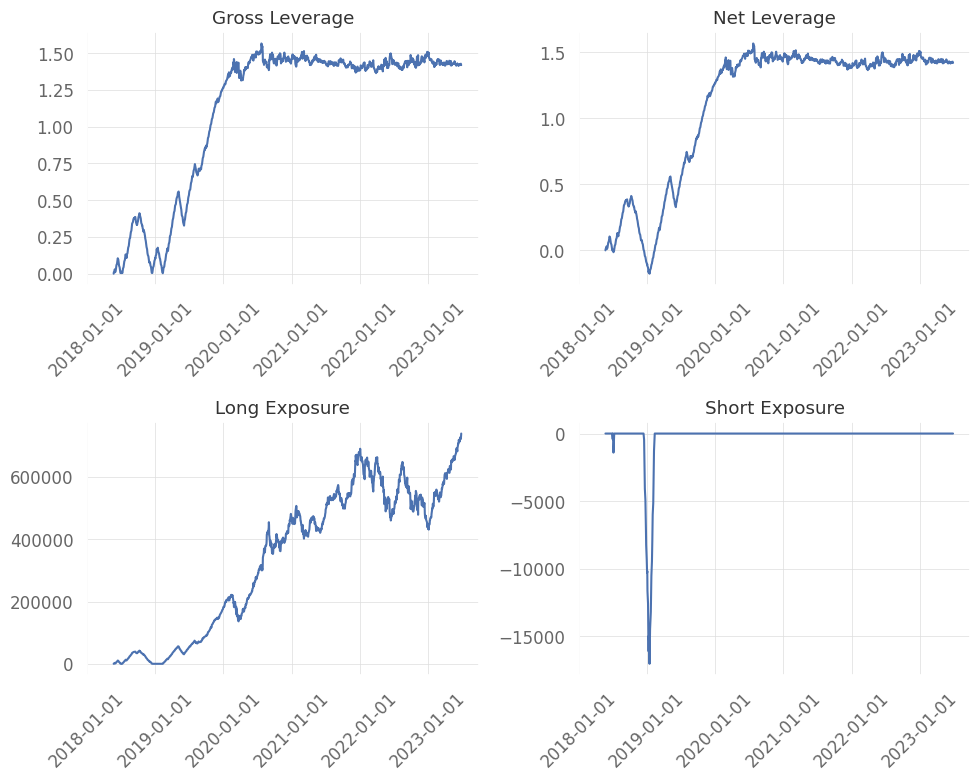

AAPL





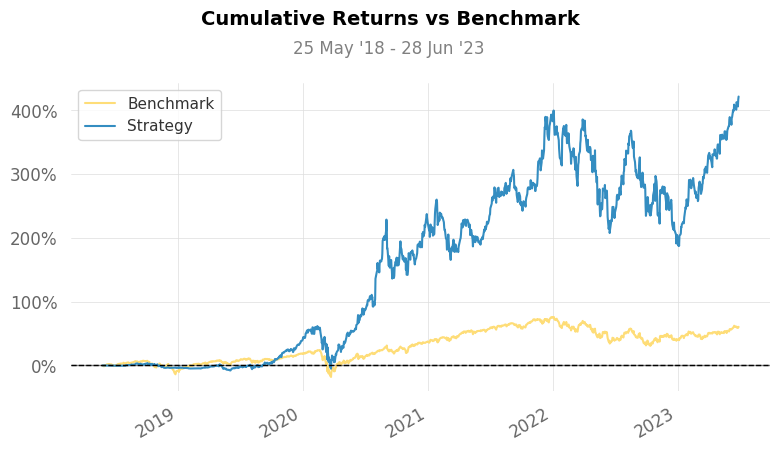

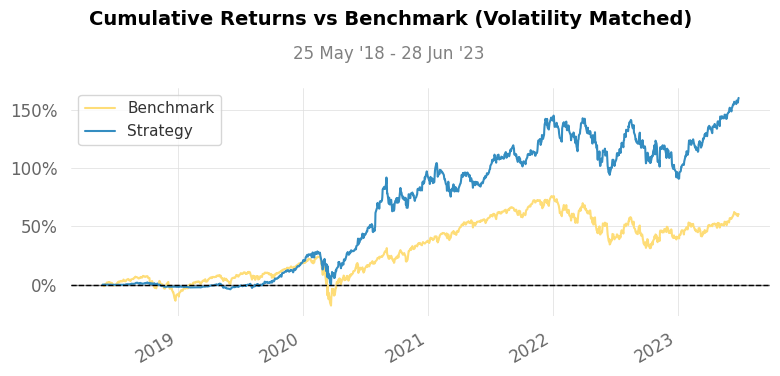

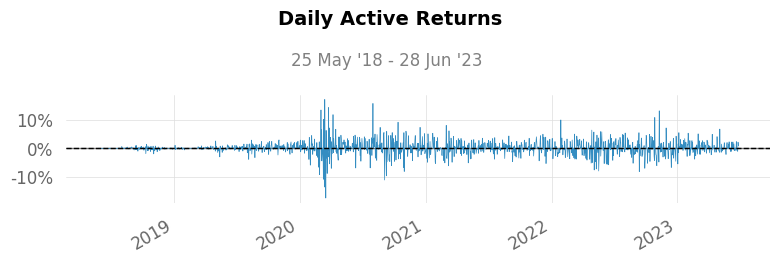

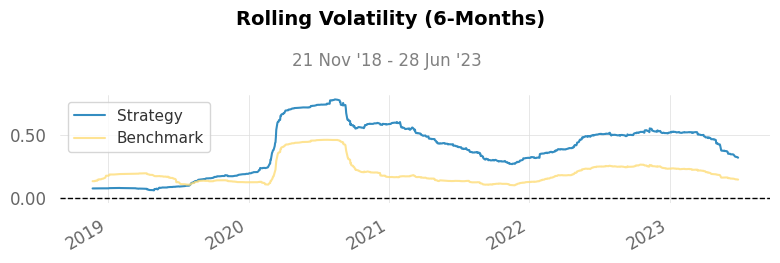

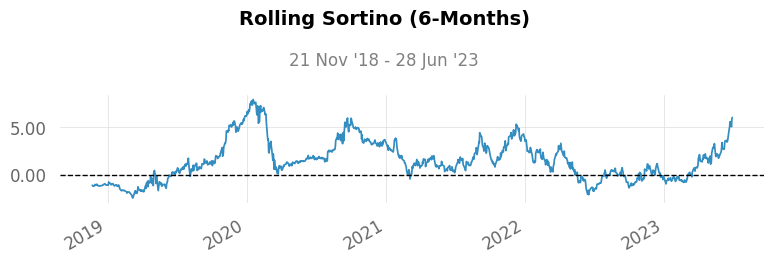

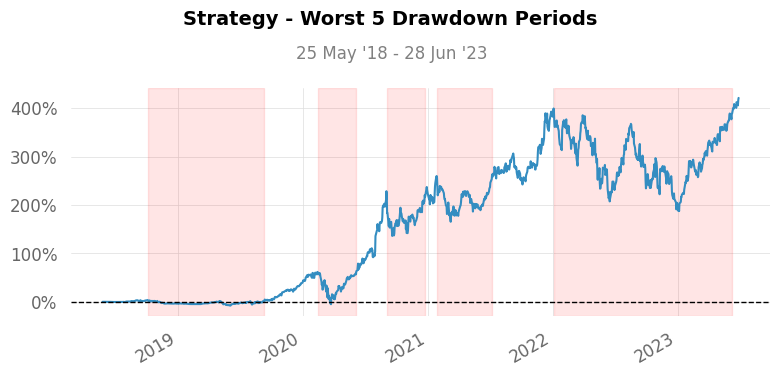

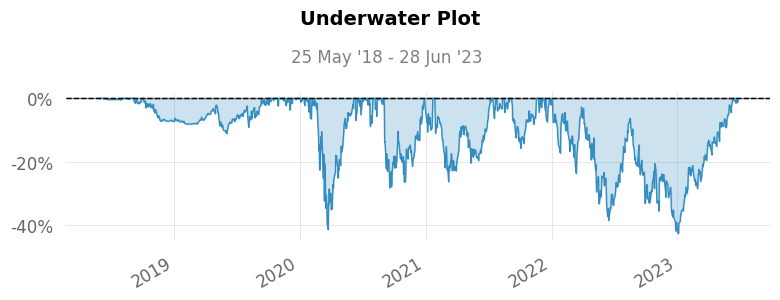

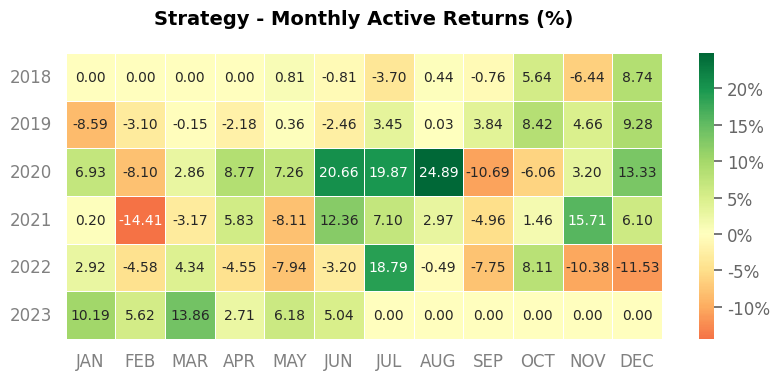

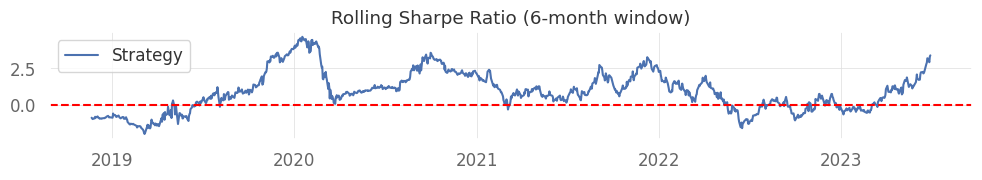

[*********************100%***********************]  1 of 1 completed


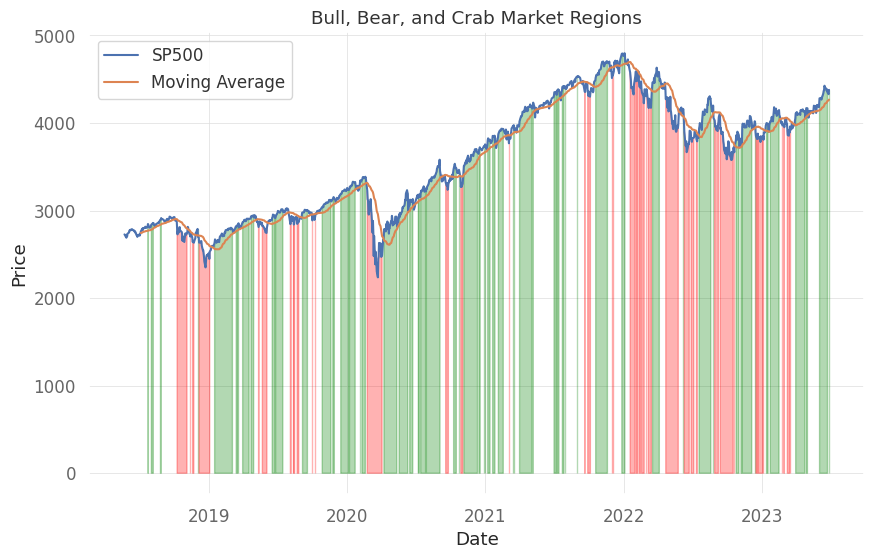

Total Trades: 1281
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





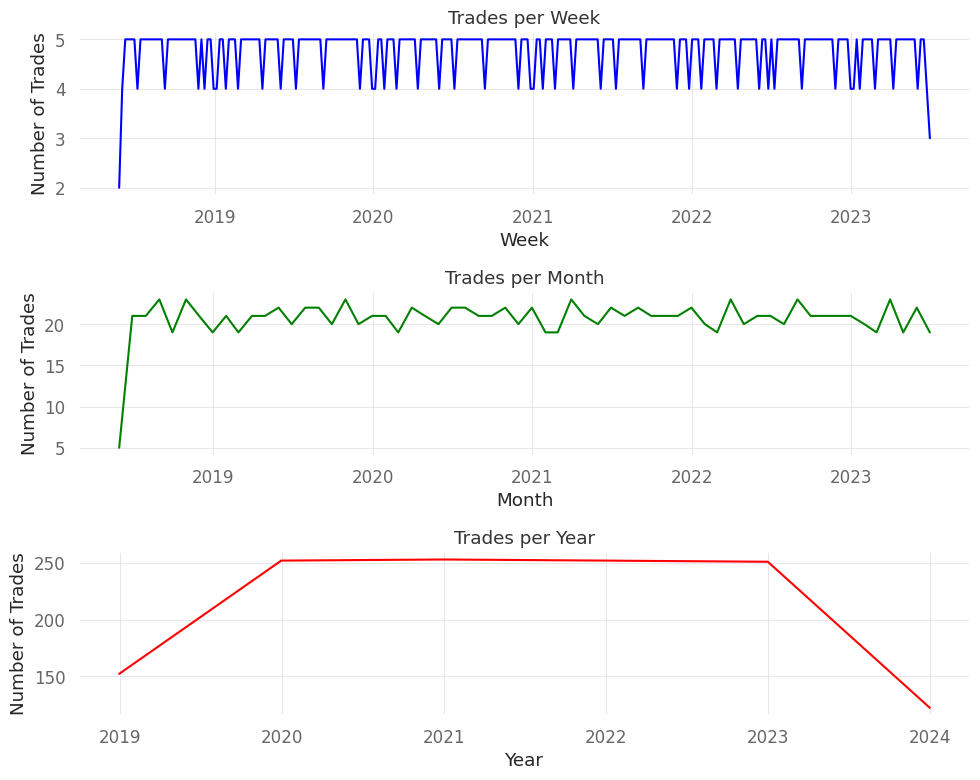

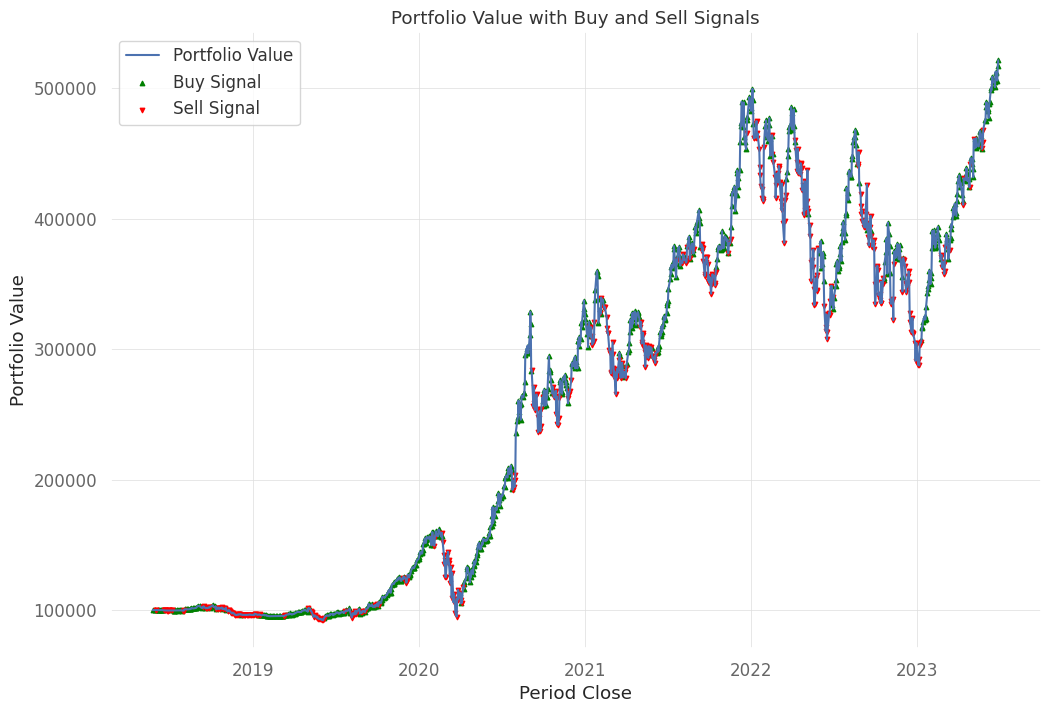

In [5]:
start = results.index[0]
end = results.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index).tz_convert(None)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)